In [2]:
import pickle, time
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re
from pathlib import Path
import pandas as pd
from typing import List, Dict
from tqdm.notebook import tqdm   
import numpy as np        

from dgd.environments.drl3env_loader4 import _apply_implicit_or, _compute_hash, _compute_truth_key

from dgd.utils.utils5 import (
    calculate_truth_table_v2,
    generate_one_hot_features_from_adj,
    resize_matrix,
    energy_score,
    check_implicit_OR_existence_v3,
    add_implicit_OR_to_dag_v2,
    exhaustive_cut_enumeration_dag,
    is_fanout_free_standalone,
    generate_subgraph,
    simulate_signal_propagation_binary,
    plot_circuit_layered,
    write_tt_files,
    calculate_truth_table
)

from dgd.utils.verification import *

Done loading action motifs. There are 15928 unique motifs.


In [3]:
MOTIFS_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/action_motifs.pkl"
with open(MOTIFS_PATH, "rb") as f:
    action_motifs = pickle.load(f)

UNIQUE_GRAPHS = action_motifs["graphs"]       
TTABLE_TO_ACTIONS = action_motifs["lookup"]

def build_motif_canonicals():
    """
    Compute canonical form for every motif in global UNIQUE_GRAPHS and
    store them in UNIQUE_GRAPHS_canonical, with a progress bar.
    """
    global UNIQUE_GRAPHS_canonical
    bar = tqdm(UNIQUE_GRAPHS, desc="Canonicalising motifs", unit="motif")
    UNIQUE_GRAPHS_canonical = [_apply_implicit_or(g.copy()) for g in bar]
    print(f"Built canonical bank for {len(UNIQUE_GRAPHS_canonical)} motifs.")
    
#plot_circuit_layered(G, show_in_notebook=True)

In [4]:
import networkx as nx
from tqdm import tqdm

def graphs_changed_by_implicit_or(
    graphs,
    node_attr_keys=None,
    edge_attr_keys=None,
    show_progress=True,
):
    """
    Compare each graph to its _apply_implicit_or-transformed version and report
    how many are non-isomorphic to their original.

    Parameters
    ----------
    graphs : list[networkx.Graph or DiGraph]
        The motifs to check (e.g., UNIQUE_GRAPHS).
    node_attr_keys : list[str] | None
        If provided, node attributes to include in the isomorphism test.
    edge_attr_keys : list[str] | None
        If provided, edge attributes to include in the isomorphism test.
    show_progress : bool
        Whether to show a tqdm progress bar.

    Returns
    -------
    count_changed : int
        Number of graphs that changed up to isomorphism.
    changed_indices : list[int]
        Indices of graphs that changed.
    """
    # Build attribute matchers if requested
    node_match = None
    edge_match = None

    if node_attr_keys:
        def node_match(a, b):
            return all(a.get(k) == b.get(k) for k in node_attr_keys)
    if edge_attr_keys:
        def edge_match(a, b):
            return all(a.get(k) == b.get(k) for k in edge_attr_keys)

    iterator = enumerate(graphs)
    if show_progress:
        iterator = tqdm(iterator, total=len(graphs), desc="Checking isomorphism", unit="graph")

    count_changed = 0
    changed_indices = []

    for i, g in iterator:
        g2 = _apply_implicit_or(g.copy())
        iso = nx.is_isomorphic(g, g2, node_match=node_match, edge_match=edge_match)
        if not iso:
            count_changed += 1
            changed_indices.append(i)

    print(f"{count_changed} / {len(graphs)} graphs changed up to isomorphism after _apply_implicit_or.")
    return count_changed, changed_indices

# --- Usage ---
count_changed, changed_idxs = graphs_changed_by_implicit_or(UNIQUE_GRAPHS)
# If you want attribute-aware matching, e.g. include 'type' on nodes and 'label' on edges:
# count_changed, changed_idxs = graphs_changed_by_implicit_or(UNIQUE_GRAPHS, node_attr_keys=["type"], edge_attr_keys=["label"])


Checking isomorphism:   0%|          | 0/15928 [00:00<?, ?graph/s]

Checking isomorphism: 100%|██████████| 15928/15928 [00:22<00:00, 704.55graph/s]

7630 / 15928 graphs changed up to isomorphism after _apply_implicit_or.


Showing 5 randomly selected changed motifs: [12180, 4768, 3204, 13406, 7545]

Changed motif index: 12180 (before → after)


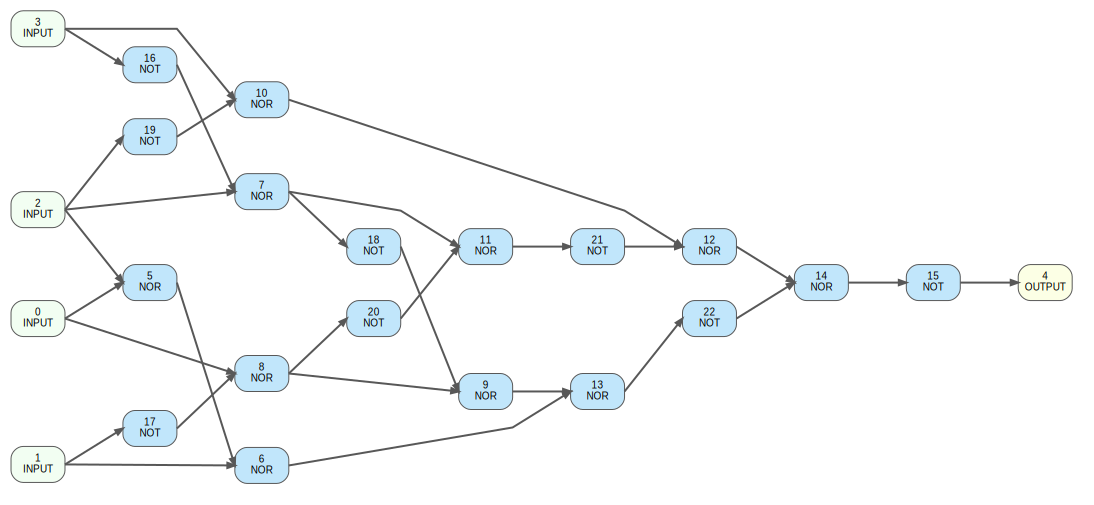

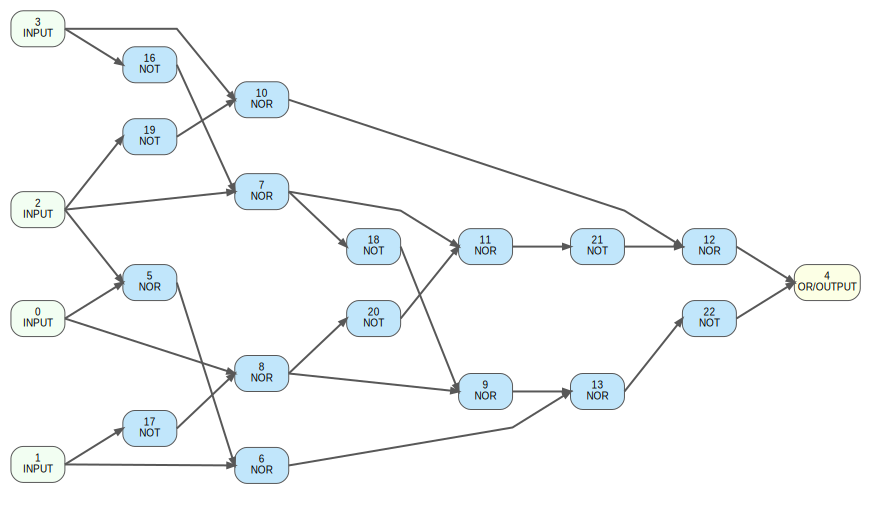


Changed motif index: 4768 (before → after)


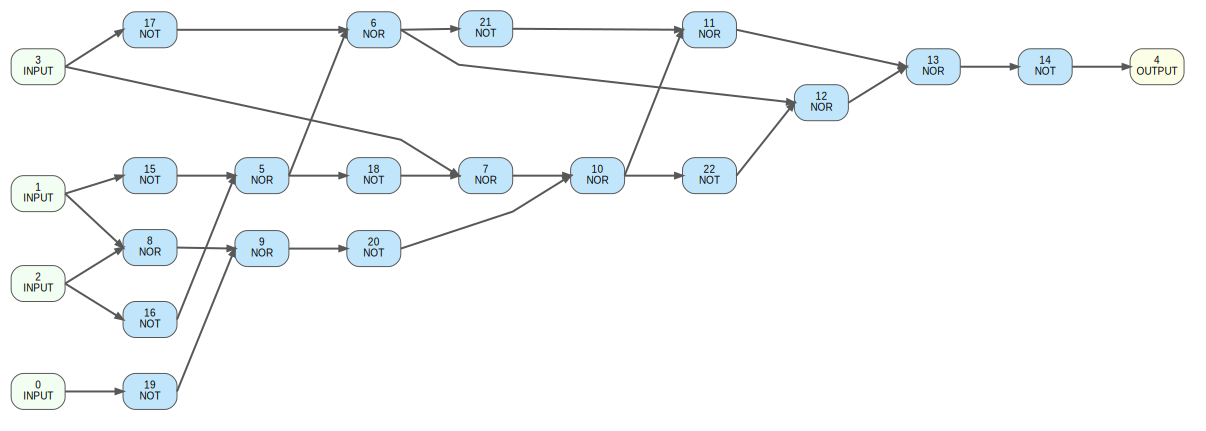

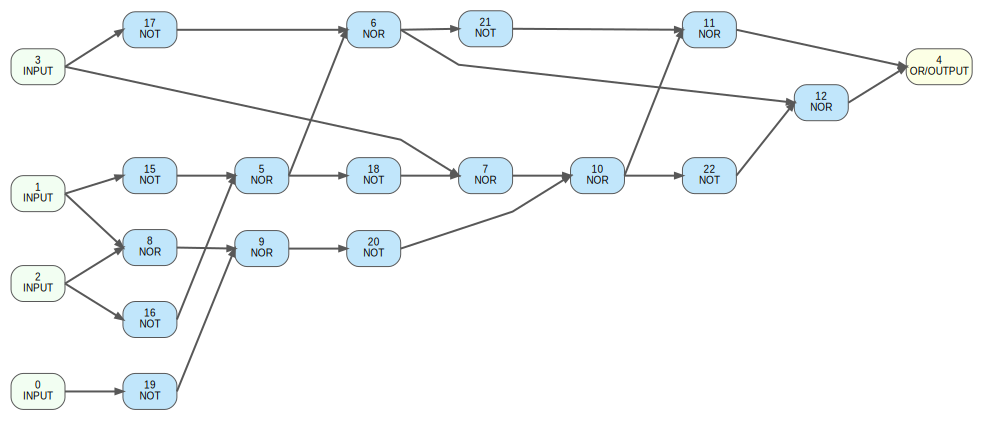


Changed motif index: 3204 (before → after)


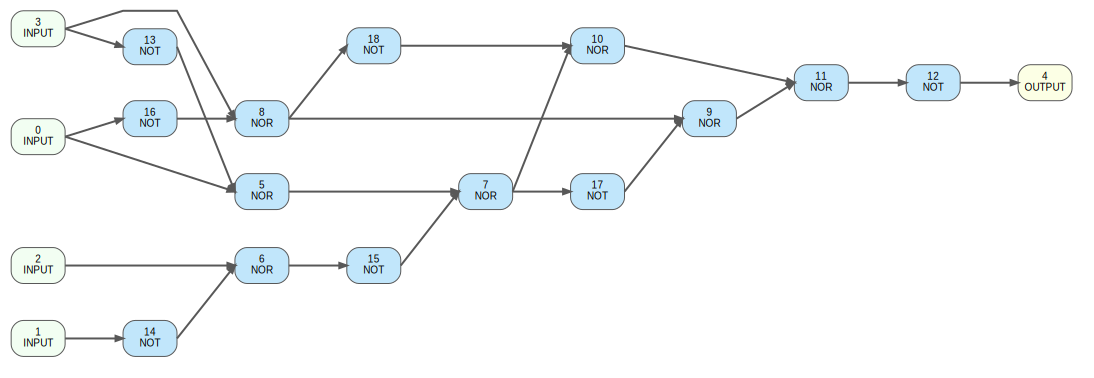

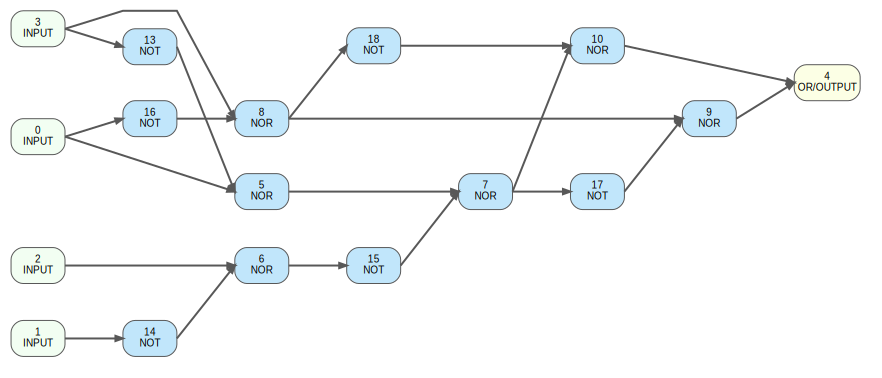


Changed motif index: 13406 (before → after)


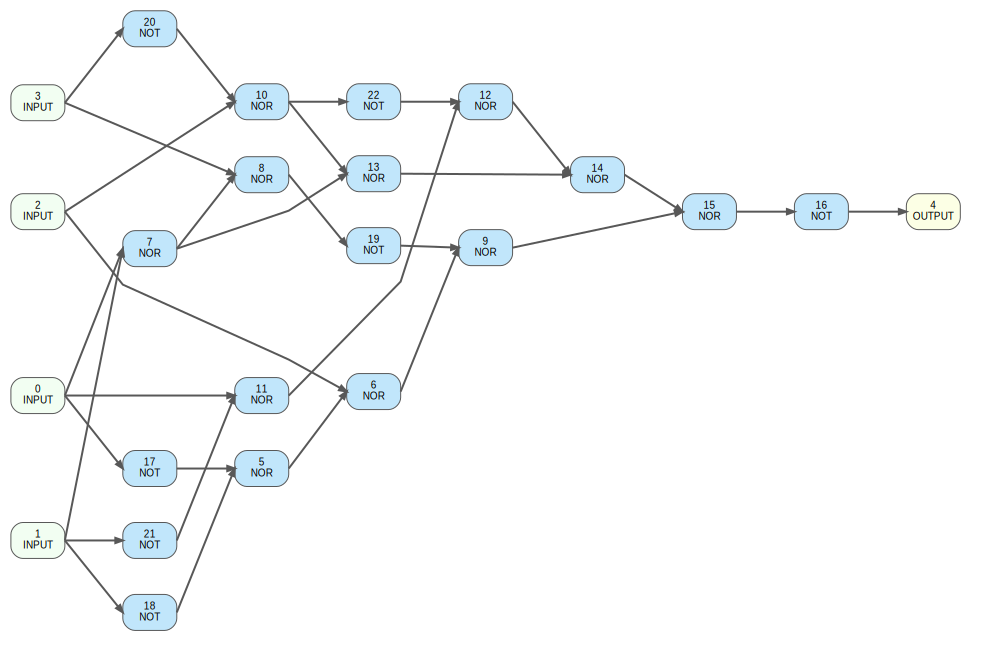

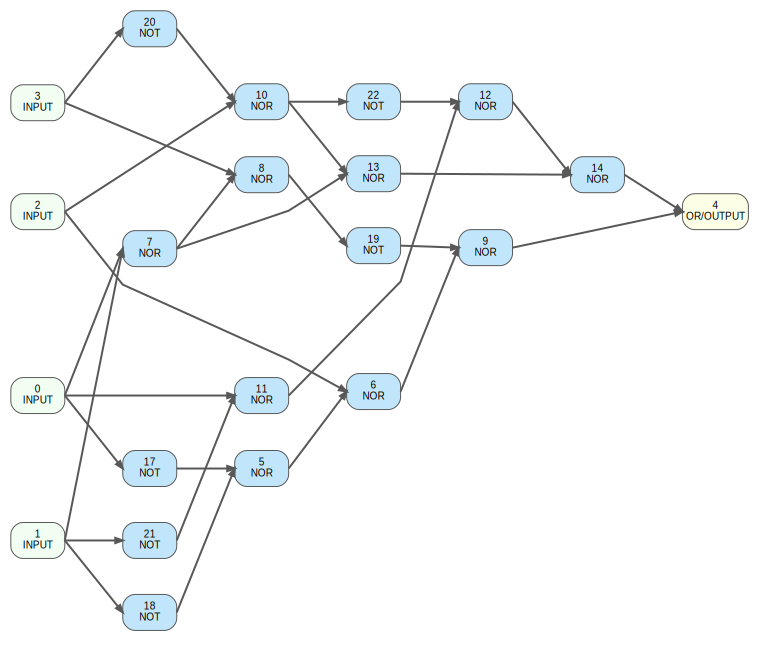


Changed motif index: 7545 (before → after)


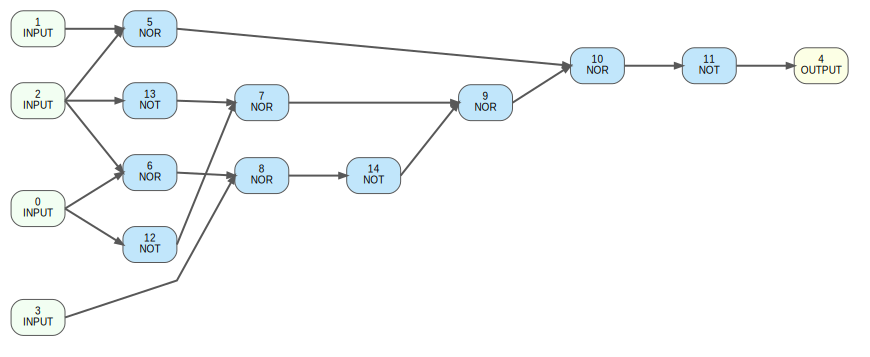

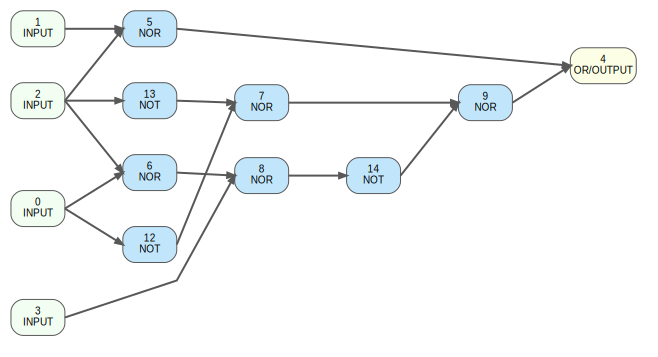

In [5]:
import random

N = 5         # how many changed motifs to visualize
seed = 42     # set None for non-deterministic sampling

if changed_idxs:
    rng = random.Random(seed)
    picks = rng.sample(changed_idxs, k=min(N, len(changed_idxs)))
    print(f"Showing {len(picks)} randomly selected changed motifs:", picks)

    for i in picks:
        G0 = UNIQUE_GRAPHS[i]
        G1 = _apply_implicit_or(G0.copy())
        print(f"\nChanged motif index: {i} (before → after)")
        plot_circuit_layered(G0, show_in_notebook=True)
        plot_circuit_layered(G1, show_in_notebook=True)
else:
    print("No changed motifs to visualize.")


Loaded 6 graphs from:
/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/experimental/scratch_training/0x2B/seed_1/optimal_topologies/optimal_topologies.pkl
UNIQUE_GRAPHS_canonical not found; building it with _apply_implicit_or...


Canonicalising motifs: 100%|██████████| 15928/15928 [00:16<00:00, 954.89motif/s] 


Built canonical bank for 15928 motifs.


Testing graphs:   0%|          | 0/6 [00:00<?, ?graph/s]


=== Test graph #0 ===


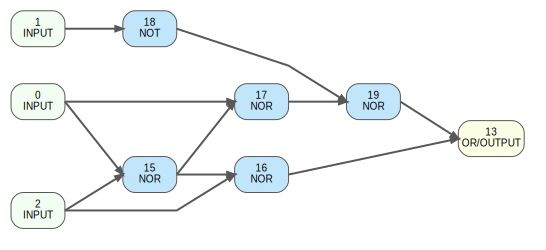

Testing graphs:  17%|█▋        | 1/6 [00:00<00:00,  6.00graph/s]

No isomorphic match found in UNIQUE_GRAPHS.
No isomorphic match found in UNIQUE_GRAPHS_canonical.

=== Test graph #1 ===


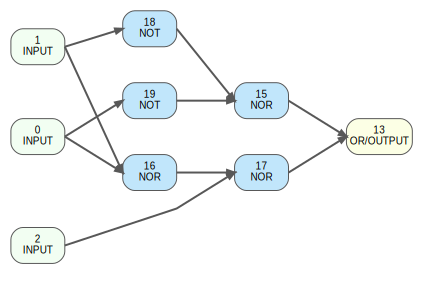

Testing graphs:  33%|███▎      | 2/6 [00:00<00:00,  5.87graph/s]

No isomorphic match found in UNIQUE_GRAPHS.
No isomorphic match found in UNIQUE_GRAPHS_canonical.

=== Test graph #2 ===


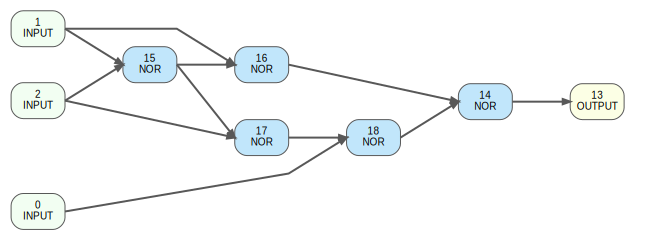

Testing graphs:  50%|█████     | 3/6 [00:00<00:00,  5.35graph/s]

Isomorphic to UNIQUE_GRAPHS indices (showing up to 5): [238]
Isomorphic to UNIQUE_GRAPHS_canonical indices (up to 5): [238]

=== Test graph #3 ===


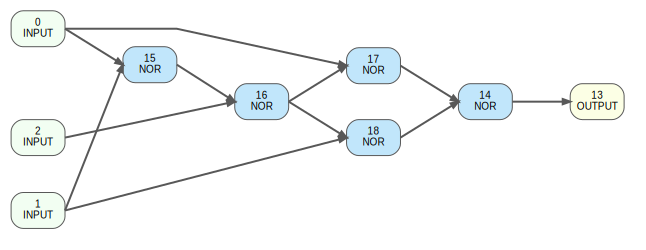

Testing graphs:  67%|██████▋   | 4/6 [00:00<00:00,  4.13graph/s]

Isomorphic to UNIQUE_GRAPHS indices (showing up to 5): [223]
Isomorphic to UNIQUE_GRAPHS_canonical indices (up to 5): [223]

=== Test graph #4 ===


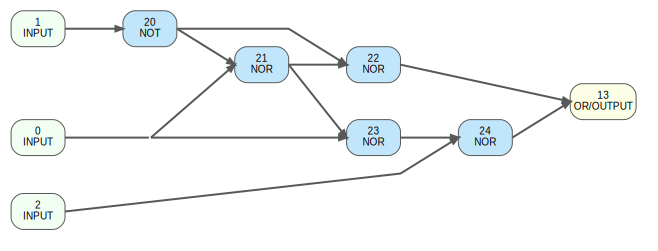

Testing graphs:  83%|████████▎ | 5/6 [00:01<00:00,  4.65graph/s]

No isomorphic match found in UNIQUE_GRAPHS.
No isomorphic match found in UNIQUE_GRAPHS_canonical.

=== Test graph #5 ===


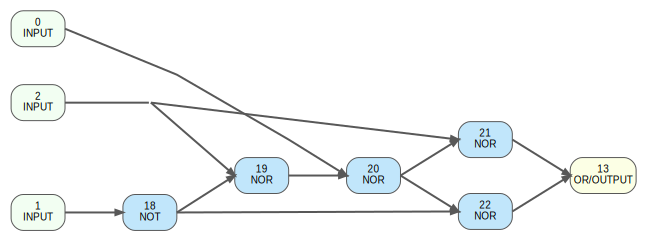

Testing graphs: 100%|██████████| 6/6 [00:01<00:00,  4.88graph/s]

No isomorphic match found in UNIQUE_GRAPHS.
No isomorphic match found in UNIQUE_GRAPHS_canonical.


In [6]:
import pickle
import os
from tqdm import tqdm
import networkx as nx

PKL_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/experimental/scratch_training/0x2B/seed_1/optimal_topologies/optimal_topologies.pkl"

# --- Load graphs to test ---
with open(PKL_PATH, "rb") as f:
    data = pickle.load(f)

# Handle either a list of graphs or a dict containing them.
if isinstance(data, dict):
    # Best guess at common keys; adjust if needed.
    for key in ["graphs", "topologies", "optimal_graphs", "Gs"]:
        if key in data:
            TEST_GRAPHS = data[key]
            break
    else:
        # Fall back: if dict values look like graphs, take all values
        TEST_GRAPHS = [v for v in data.values() if hasattr(v, "nodes") and hasattr(v, "edges")]
else:
    TEST_GRAPHS = data

assert isinstance(TEST_GRAPHS, (list, tuple)), "Loaded object does not contain a list/tuple of graphs."
print(f"Loaded {len(TEST_GRAPHS)} graphs from:\n{PKL_PATH}")

# --- Ensure UNIQUE_GRAPHS_canonical is available ---
try:
    _ = UNIQUE_GRAPHS_canonical  # noqa
except NameError:
    print("UNIQUE_GRAPHS_canonical not found; building it with _apply_implicit_or...")
    UNIQUE_GRAPHS_canonical = [_apply_implicit_or(g.copy()) for g in tqdm(UNIQUE_GRAPHS, desc="Canonicalising motifs", unit="motif")]
    print(f"Built canonical bank for {len(UNIQUE_GRAPHS_canonical)} motifs.")

# --- Utilities for fast candidate pruning before isomorphism checks ---
def graph_signature(G):
    """Simple structure-only signature for candidate pruning."""
    n = G.number_of_nodes()
    m = G.number_of_edges()
    if isinstance(G, (nx.DiGraph, nx.MultiDiGraph)):
        degs = sorted((G.in_degree(v), G.out_degree(v)) for v in G.nodes())
    else:
        degs = sorted(G.degree(v) for v in G.nodes())
    return (n, m, tuple(degs))

def build_sig_index(graphs):
    """Map signature -> list of indices in graphs."""
    sig_index = {}
    for i, g in enumerate(graphs):
        sig = graph_signature(g)
        sig_index.setdefault(sig, []).append(i)
    return sig_index

SIG_UNIQUE = build_sig_index(UNIQUE_GRAPHS)
SIG_CANON  = build_sig_index(UNIQUE_GRAPHS_canonical)

def iso_matches_against_bank(G, bank, sig_index, max_report=5):
    """Return up to max_report indices of isomorphic matches in bank."""
    sig = graph_signature(G)
    candidates = sig_index.get(sig, [])
    hits = []
    for j in candidates:
        if nx.is_isomorphic(G, bank[j]):
            hits.append(j)
            if len(hits) >= max_report:
                break
    return hits

# --- Loop over test graphs: plot + check isomorphism ---
for idx, G in enumerate(tqdm(TEST_GRAPHS, desc="Testing graphs", unit="graph")):
    print(f"\n=== Test graph #{idx} ===")
    plot_circuit_layered(G, show_in_notebook=True)

    hits_unique = iso_matches_against_bank(G, UNIQUE_GRAPHS, SIG_UNIQUE, max_report=5)
    if hits_unique:
        print(f"Isomorphic to UNIQUE_GRAPHS indices (showing up to 5): {hits_unique}")
    else:
        print("No isomorphic match found in UNIQUE_GRAPHS.")

    hits_canon = iso_matches_against_bank(G, UNIQUE_GRAPHS_canonical, SIG_CANON, max_report=5)
    if hits_canon:
        print(f"Isomorphic to UNIQUE_GRAPHS_canonical indices (up to 5): {hits_canon}")
    else:
        print("No isomorphic match found in UNIQUE_GRAPHS_canonical.")


Comparing cannonical to function that removes NOR/NOT

In [7]:
def apply_nor_not_to_or_by_degree(G: nx.DiGraph) -> nx.DiGraph:
    """
    Detects a NOR->NOT motif feeding an output (node with out_degree == 0) and
    replaces it with direct edges from the NOR's two inputs to the output
    (i.e., OR). Gate types are inferred purely from in-degrees:

      - Input: in_degree == 0
      - NOT:   in_degree == 1
      - NOR:   in_degree == 2
      - Output: out_degree == 0

    Rules:
      - Only triggers when the output has exactly one predecessor (the NOT).
      - The NOT must have exactly one predecessor (the NOR).
      - The NOR must have exactly two predecessors (its inputs).
    """
    G_canonical = G.copy()

    # Identify outputs
    outputs = [n for n in G_canonical if G_canonical.out_degree(n) == 0]

    for out in outputs:
        preds_out = list(G_canonical.predecessors(out))
        if len(preds_out) != 1:
            continue  # only handle single NOT feeding the output

        not_node = preds_out[0]
        if G_canonical.in_degree(not_node) != 1:
            continue  # NOT must have exactly 1 input

        # The NOT's single predecessor should be a NOR
        not_inputs = list(G_canonical.predecessors(not_node))
        if len(not_inputs) != 1:
            continue
        nor_node = not_inputs[0]

        if G_canonical.in_degree(nor_node) != 2:
            continue  # NOR must have exactly 2 inputs

        # Capture NOR inputs before mutations
        nor_inputs = list(G_canonical.predecessors(nor_node))
        if len(nor_inputs) != 2:
            continue  # safety (graph may have changed mid-iteration)

        # Remove NOT->output edge (if present) and delete NOR/NOT nodes
        if G_canonical.has_edge(not_node, out):
            G_canonical.remove_edge(not_node, out)

        # Remove the NOR and NOT nodes (and all incident edges)
        # Order doesn't matter because we cached `nor_inputs`.
        if nor_node in G_canonical:
            G_canonical.remove_node(nor_node)
        if not_node in G_canonical:
            G_canonical.remove_node(not_node)

        # Wire each former NOR input directly into the output (OR)
        for src in nor_inputs:
            if src != out:           # avoid accidental self-loop
                G_canonical.add_edge(src, out) # DiGraph ignores duplicate edges

    return G_canonical


In [8]:
import networkx as nx
from tqdm import tqdm

def graphs_changed_by_simple_implicit_or(
    graphs,
    node_attr_keys=None,
    edge_attr_keys=None,
    show_progress=True,
):
    """
    Compare each graph to its _apply_implicit_or-transformed version and report
    how many are non-isomorphic to their original.

    Parameters
    ----------
    graphs : list[networkx.Graph or DiGraph]
        The motifs to check (e.g., UNIQUE_GRAPHS).
    node_attr_keys : list[str] | None
        If provided, node attributes to include in the isomorphism test.
    edge_attr_keys : list[str] | None
        If provided, edge attributes to include in the isomorphism test.
    show_progress : bool
        Whether to show a tqdm progress bar.

    Returns
    -------
    count_changed : int
        Number of graphs that changed up to isomorphism.
    changed_indices : list[int]
        Indices of graphs that changed.
    """
    # Build attribute matchers if requested
    node_match = None
    edge_match = None

    if node_attr_keys:
        def node_match(a, b):
            return all(a.get(k) == b.get(k) for k in node_attr_keys)
    if edge_attr_keys:
        def edge_match(a, b):
            return all(a.get(k) == b.get(k) for k in edge_attr_keys)

    iterator = enumerate(graphs)
    if show_progress:
        iterator = tqdm(iterator, total=len(graphs), desc="Checking isomorphism", unit="graph")

    count_changed = 0
    changed_indices = []

    for i, g in iterator:
        g2 = apply_nor_not_to_or_by_degree(g.copy())
        iso = nx.is_isomorphic(g, g2, node_match=node_match, edge_match=edge_match)
        if not iso:
            count_changed += 1
            changed_indices.append(i)

    print(f"{count_changed} / {len(graphs)} graphs changed up to isomorphism after _apply_implicit_or.")
    return count_changed, changed_indices

# --- Usage ---
count_changed, changed_idxs = graphs_changed_by_simple_implicit_or(UNIQUE_GRAPHS)

Checking isomorphism:   0%|          | 0/15928 [00:00<?, ?graph/s]

Checking isomorphism: 100%|██████████| 15928/15928 [00:10<00:00, 1483.04graph/s]

7624 / 15928 graphs changed up to isomorphism after _apply_implicit_or.


Showing 5 randomly selected changed motifs: [12186, 4781, 3223, 13418, 7555]

Changed motif index: 12186 (before → after)


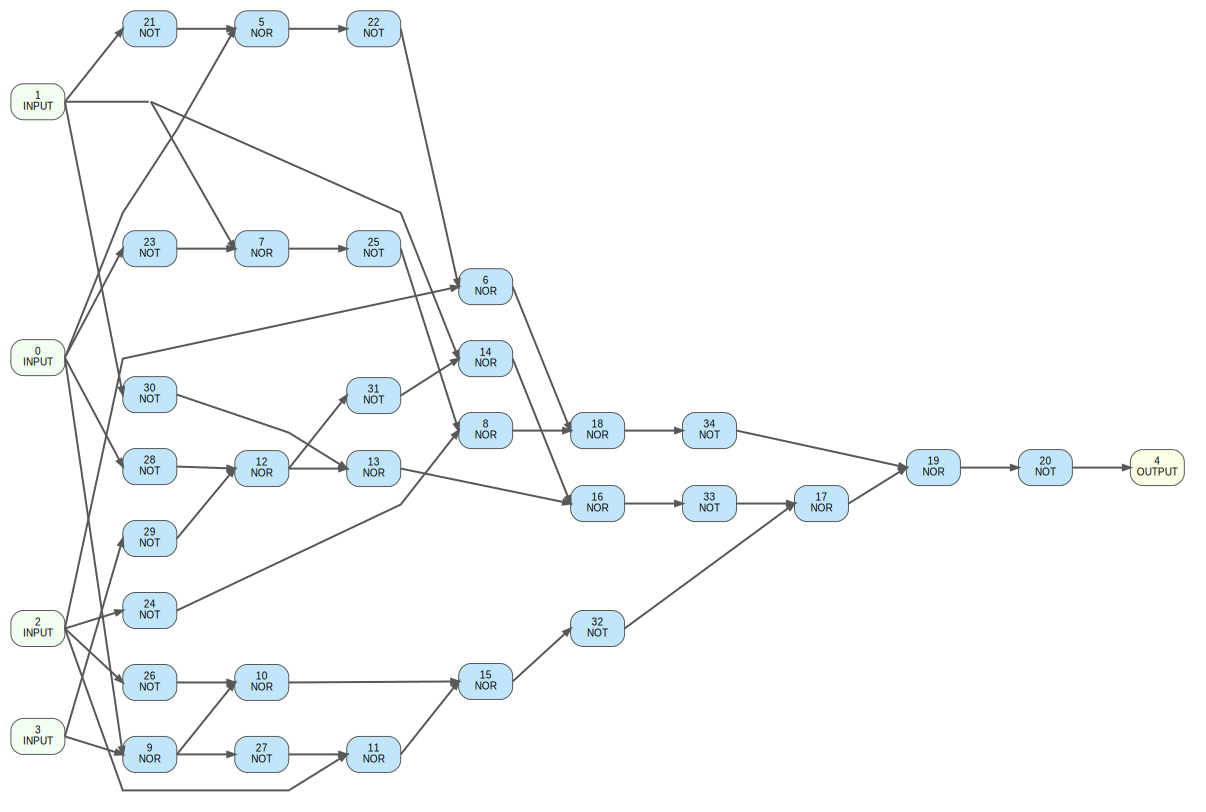

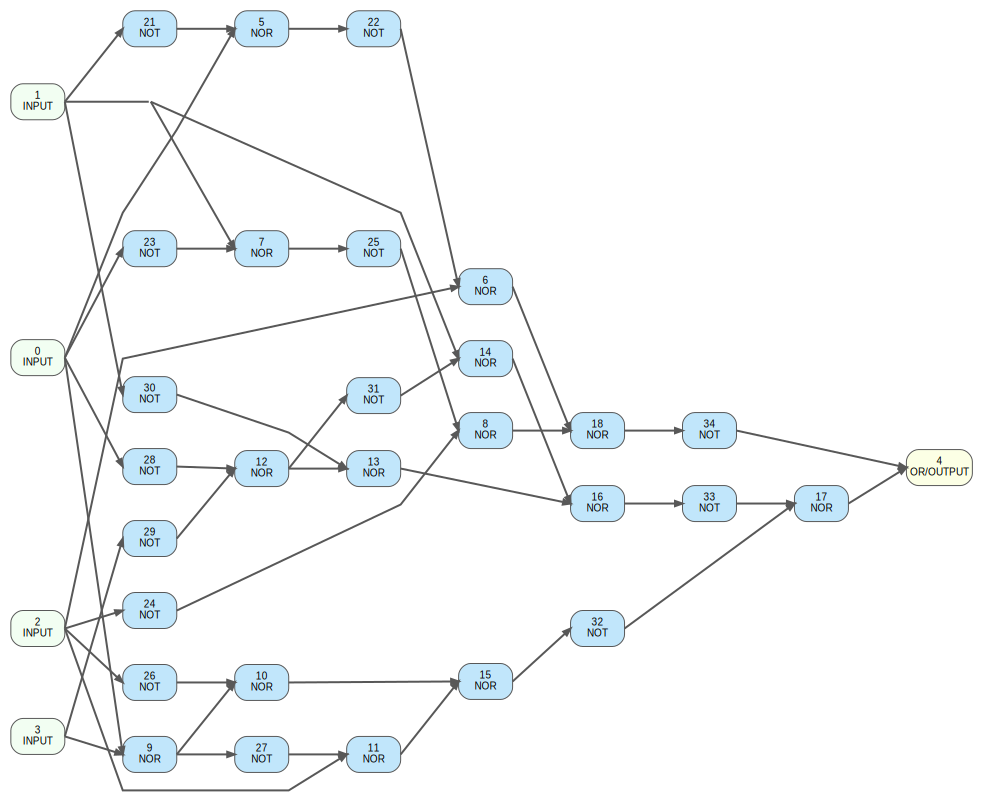


Changed motif index: 4781 (before → after)


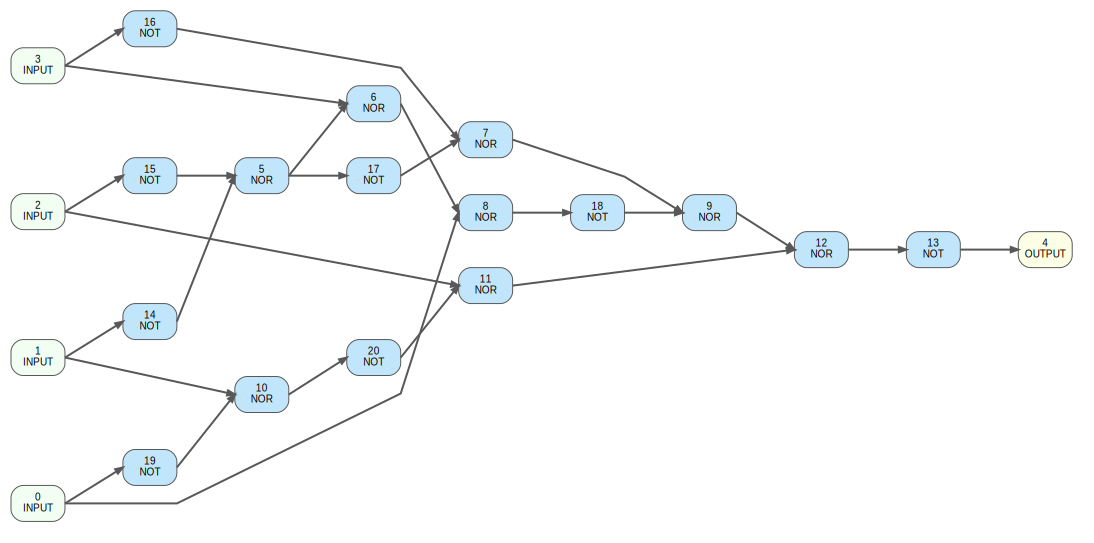

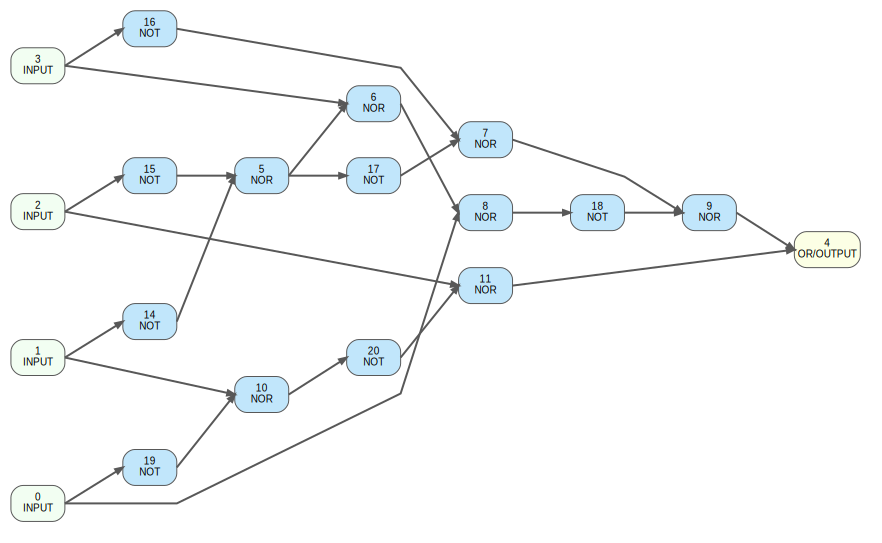


Changed motif index: 3223 (before → after)


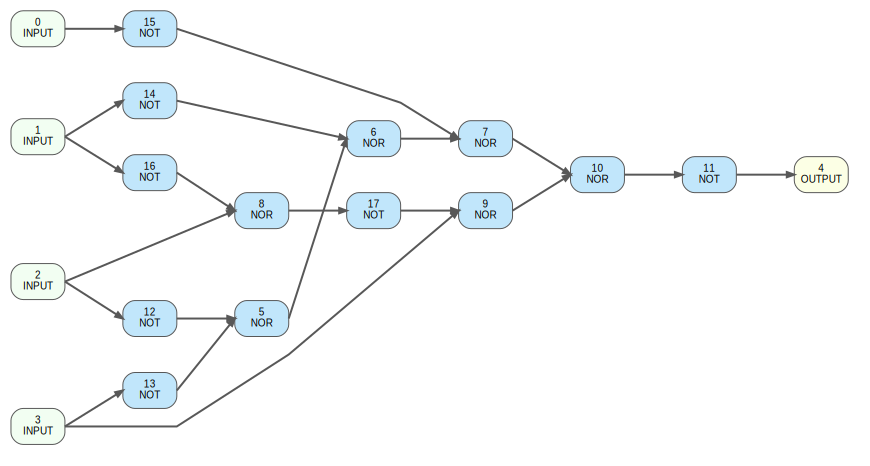

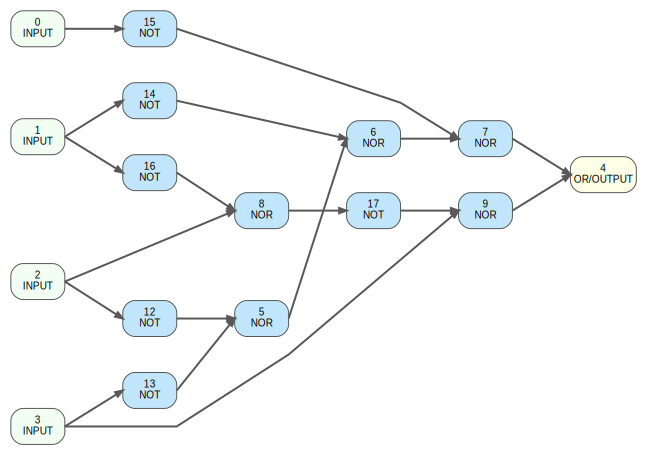


Changed motif index: 13418 (before → after)


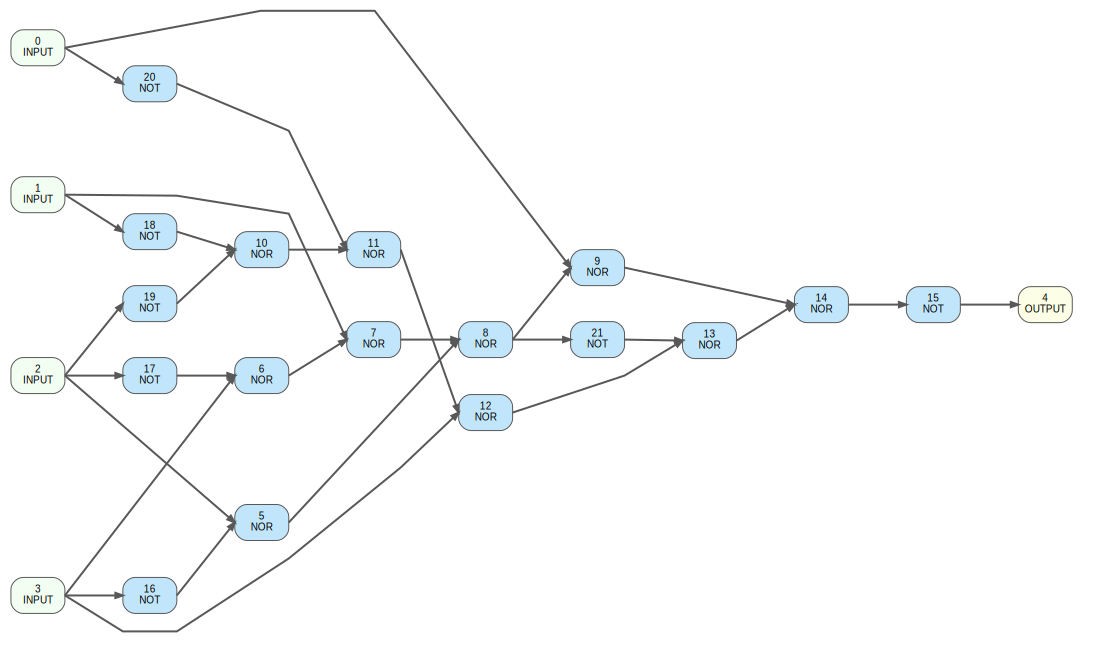

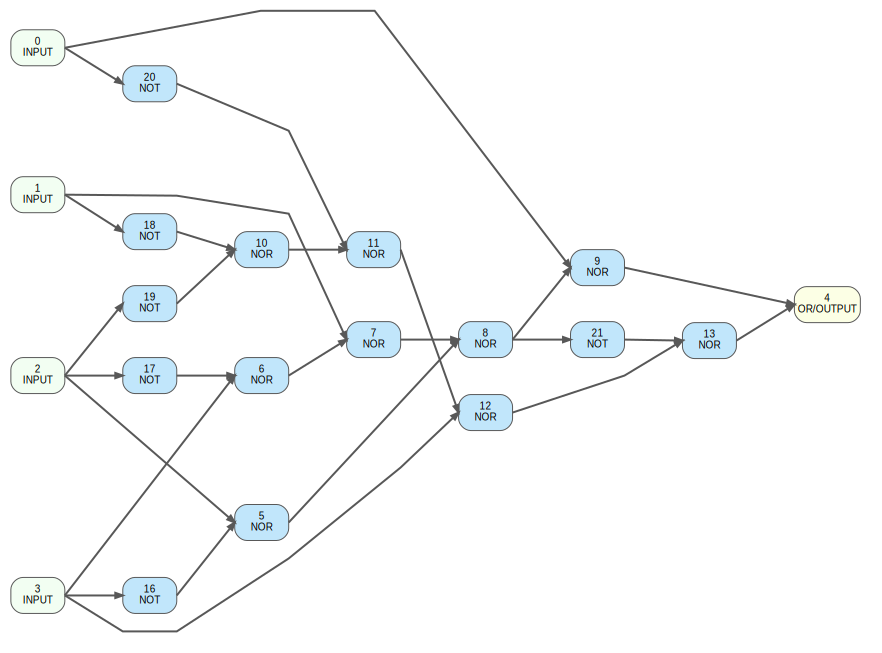


Changed motif index: 7555 (before → after)


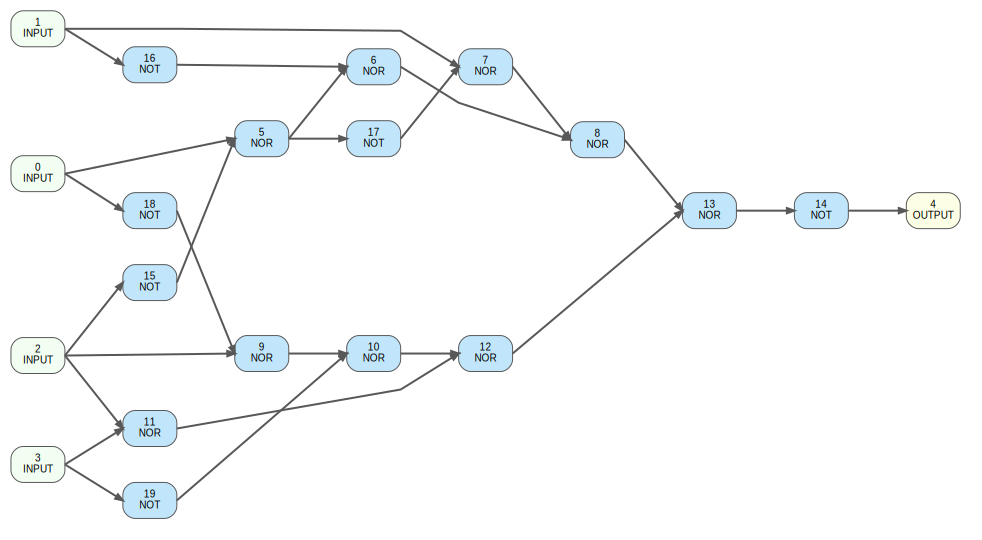

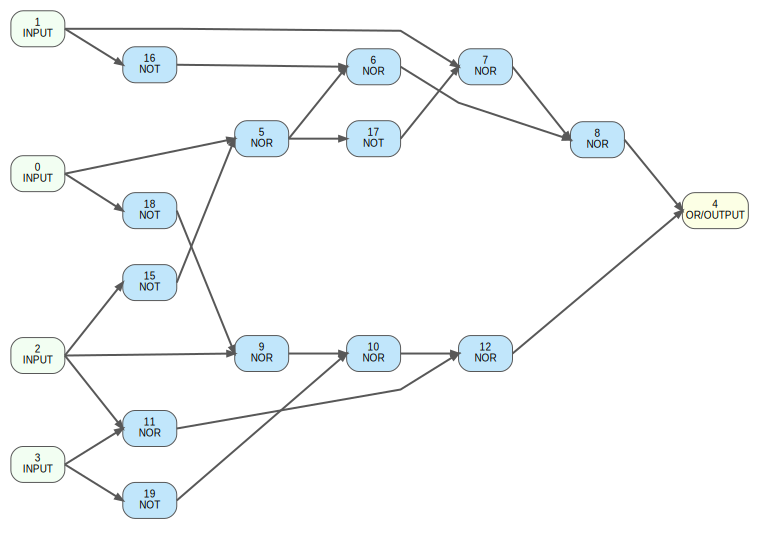

In [9]:
import random

N = 5         # how many changed motifs to visualize
seed = 42     # set None for non-deterministic sampling

if changed_idxs:
    rng = random.Random(seed)
    picks = rng.sample(changed_idxs, k=min(N, len(changed_idxs)))
    print(f"Showing {len(picks)} randomly selected changed motifs:", picks)

    for i in picks:
        G0 = UNIQUE_GRAPHS[i]
        G1 = apply_nor_not_to_or_by_degree(G0.copy())
        print(f"\nChanged motif index: {i} (before → after)")
        plot_circuit_layered(G0, show_in_notebook=True)
        plot_circuit_layered(G1, show_in_notebook=True)
else:
    print("No changed motifs to visualize.")

Integrated analysis using both approaches (cuts and simple NOR/NOT check)

Comparing transforms:   0%|          | 0/15928 [00:00<?, ?graph/s]

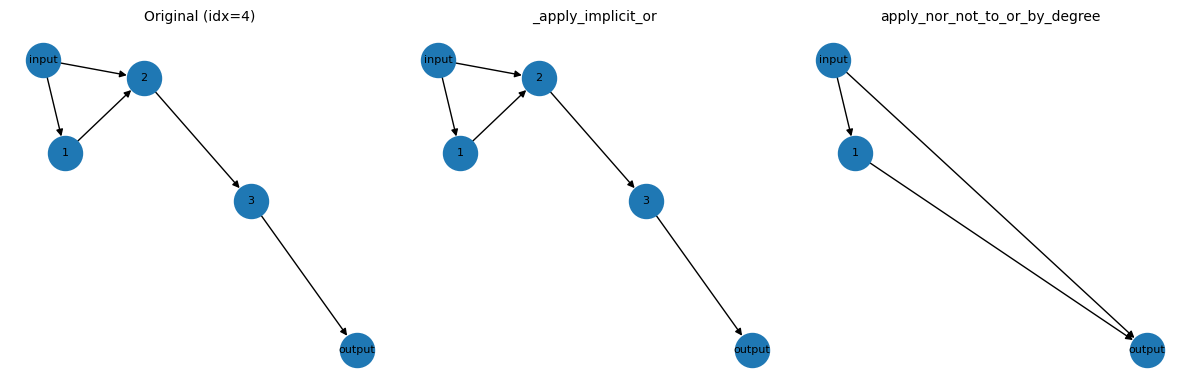

Comparing transforms:   0%|          | 5/15928 [00:00<37:37,  7.05graph/s]

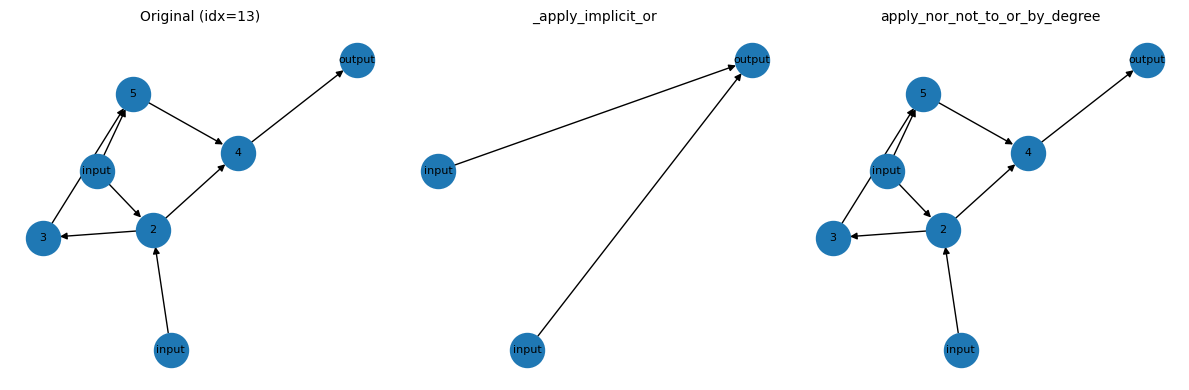

Comparing transforms:   0%|          | 14/15928 [00:01<21:20, 12.43graph/s]

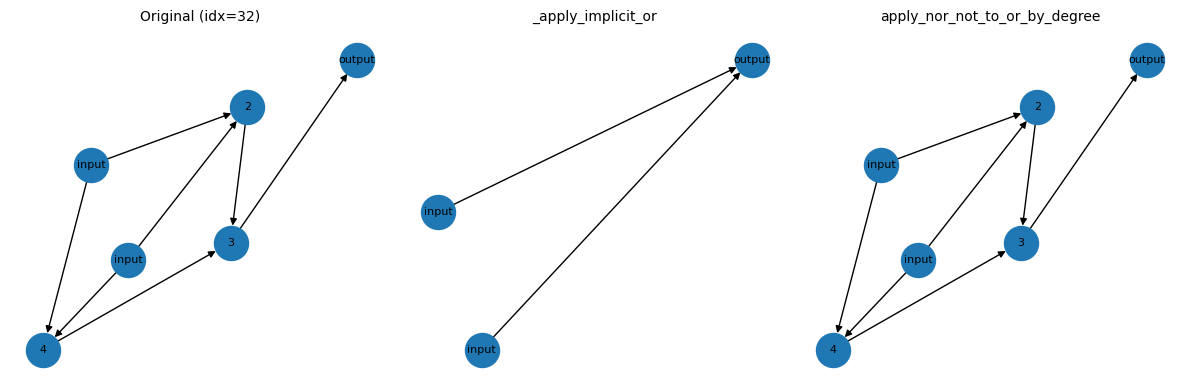

Comparing transforms:   0%|          | 33/15928 [00:03<23:58, 11.05graph/s]

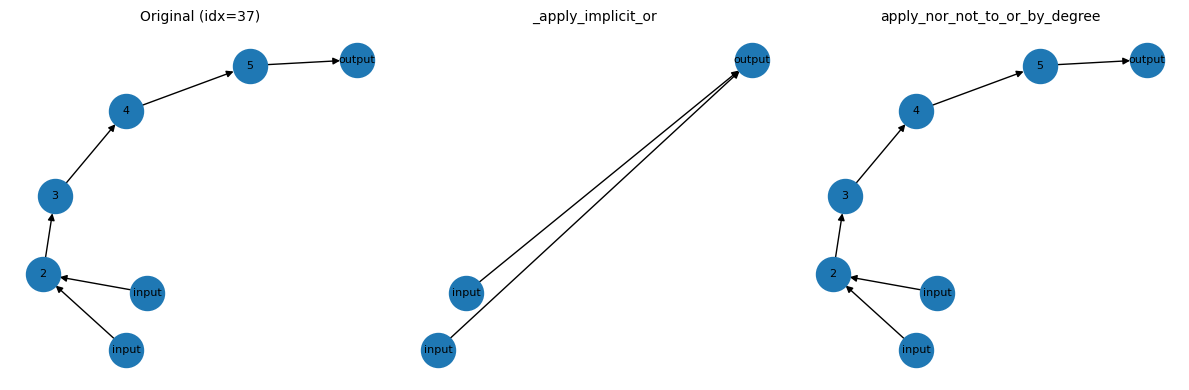

Comparing transforms:   0%|          | 38/15928 [00:03<23:49, 11.12graph/s]

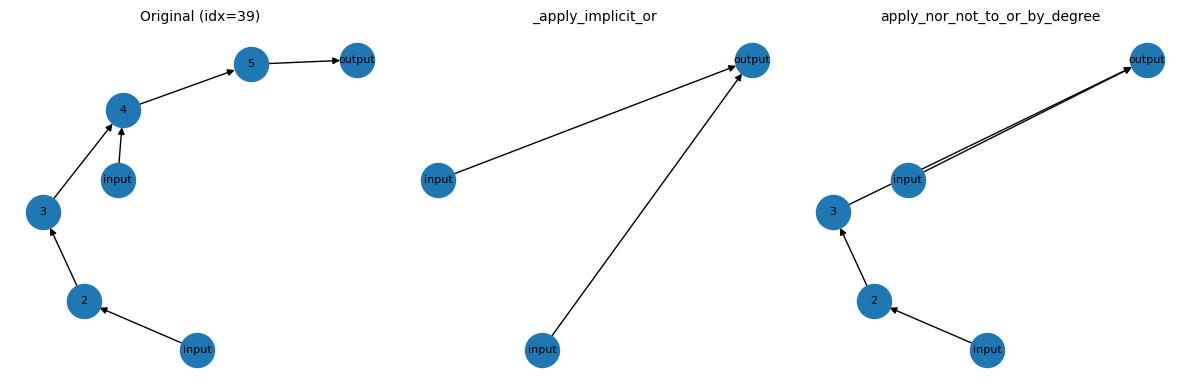

Comparing transforms:   0%|          | 40/15928 [00:03<26:49,  9.87graph/s]

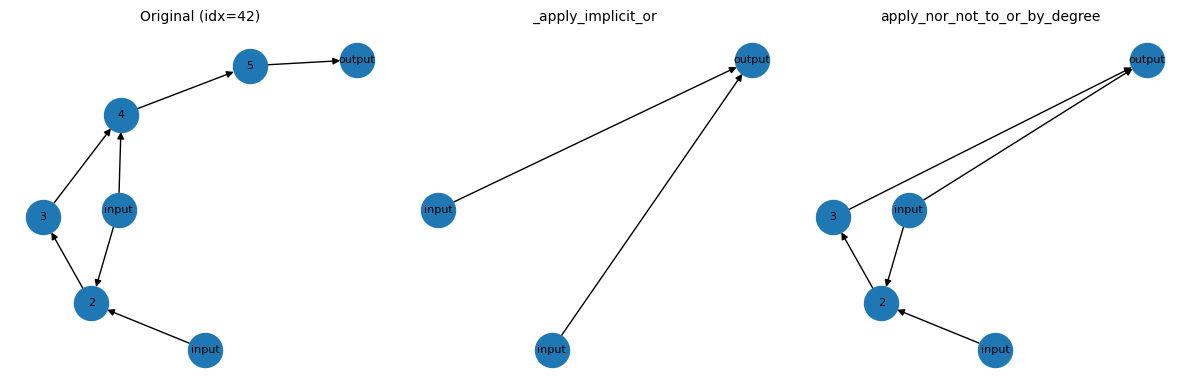

Comparing transforms:   0%|          | 43/15928 [00:04<28:12,  9.39graph/s]

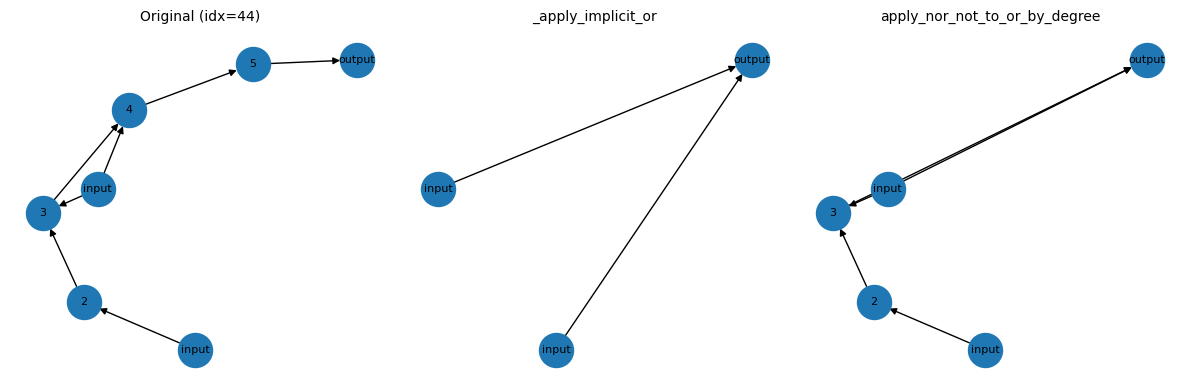

Comparing transforms:   0%|          | 45/15928 [00:04<31:55,  8.29graph/s]

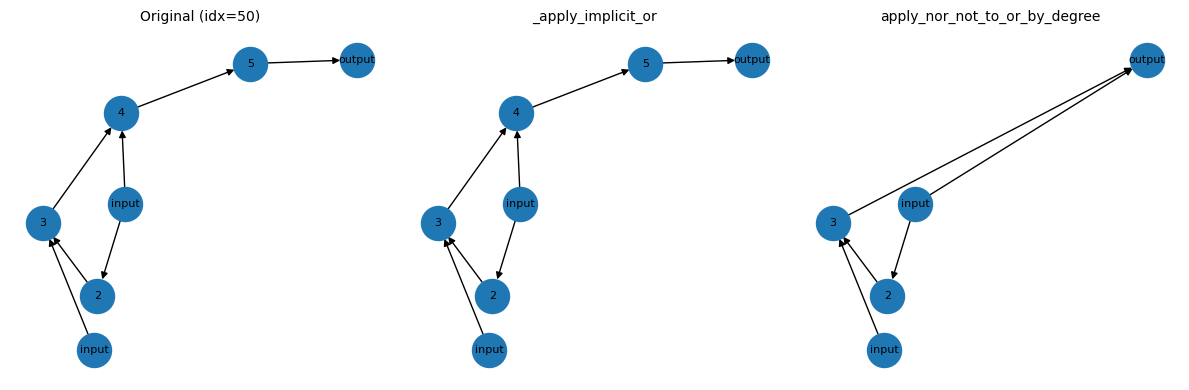

Comparing transforms:   0%|          | 51/15928 [00:05<26:53,  9.84graph/s]

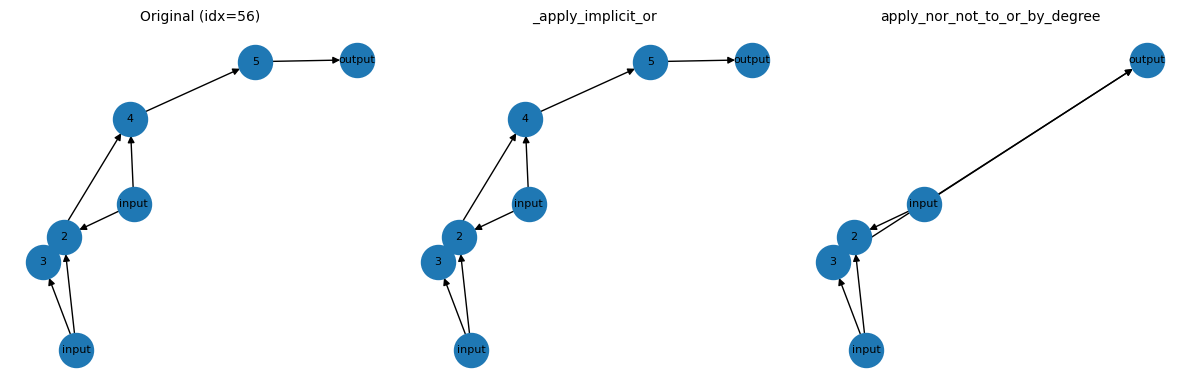

Comparing transforms:   0%|          | 57/15928 [00:05<23:51, 11.09graph/s]

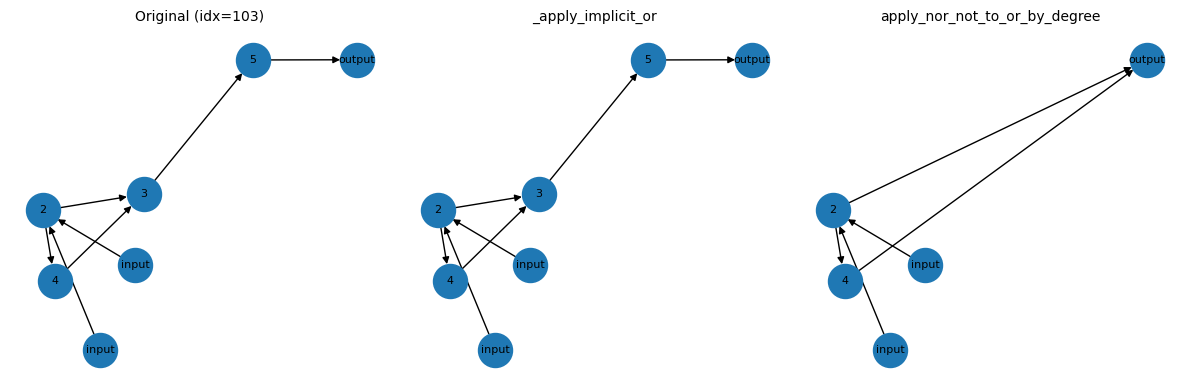

Comparing transforms:   1%|          | 104/15928 [00:05<06:57, 37.87graph/s]

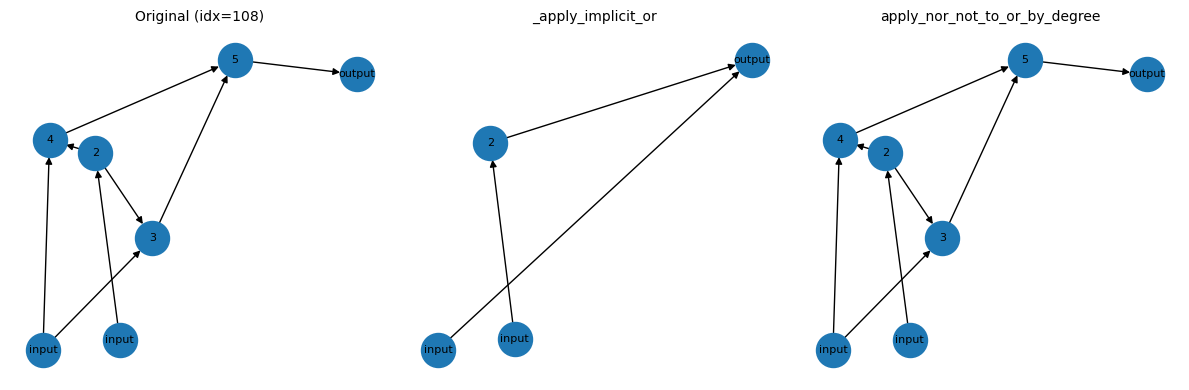

Comparing transforms:   1%|          | 109/15928 [00:06<08:31, 30.94graph/s]

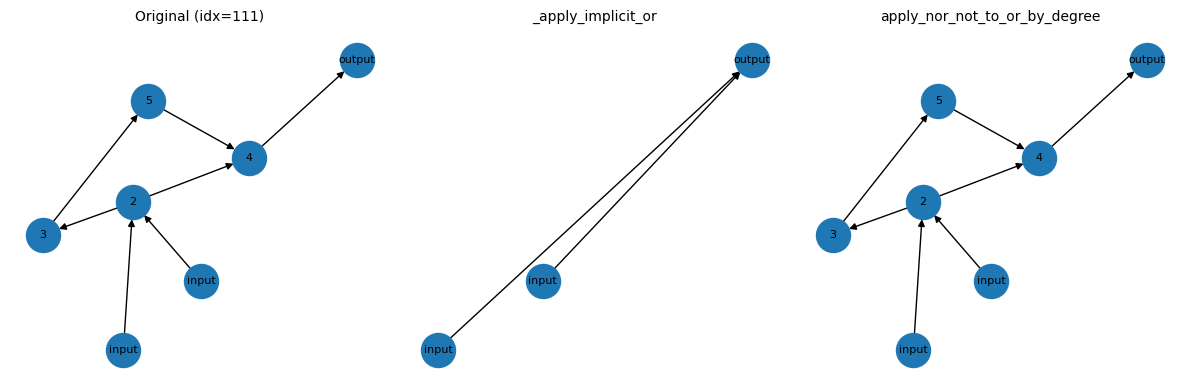

Comparing transforms:   1%|▏         | 228/15928 [00:06<01:59, 131.66graph/s]

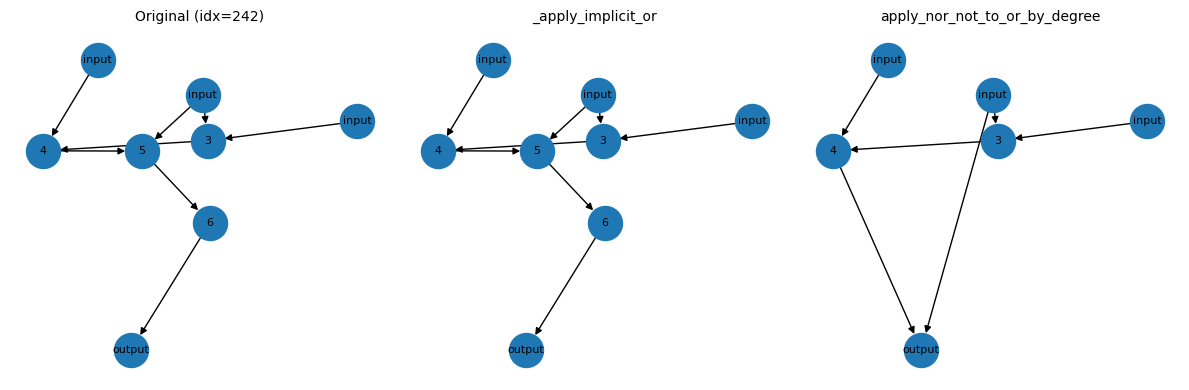

Comparing transforms:   2%|▏         | 259/15928 [00:07<02:29, 104.50graph/s]

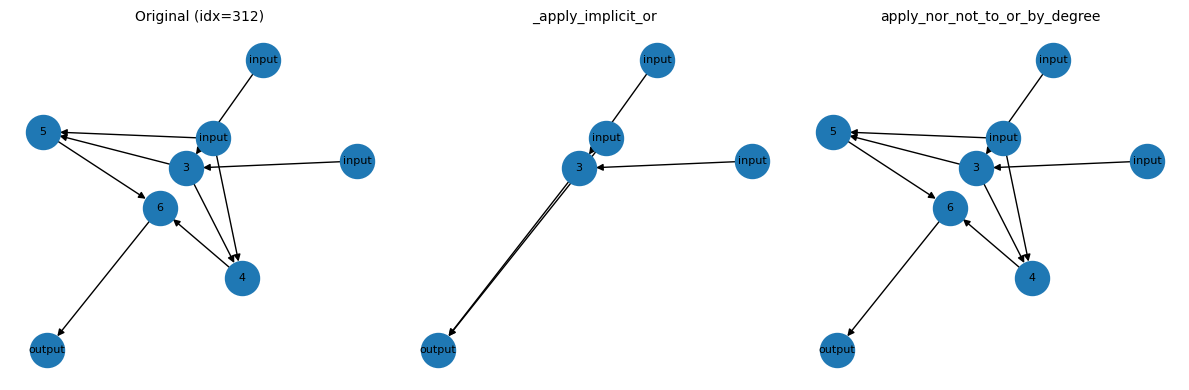

Comparing transforms:   6%|▌         | 956/15928 [00:09<00:30, 483.66graph/s]

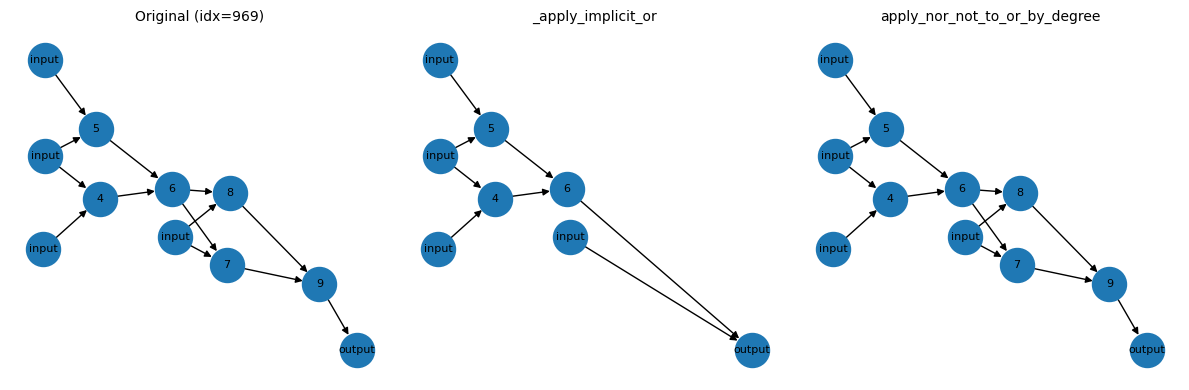

Comparing transforms:  10%|▉         | 1514/15928 [00:10<00:37, 381.65graph/s]

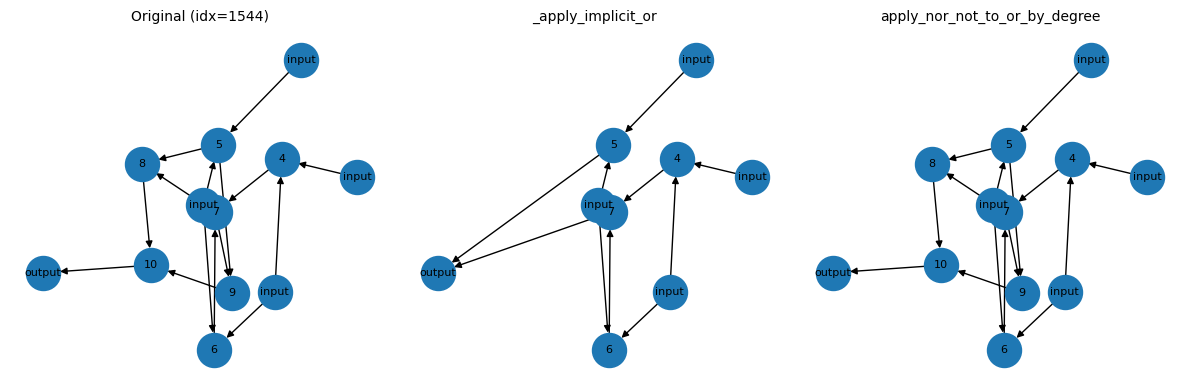

Comparing transforms:  10%|▉         | 1553/15928 [00:11<01:41, 141.28graph/s]

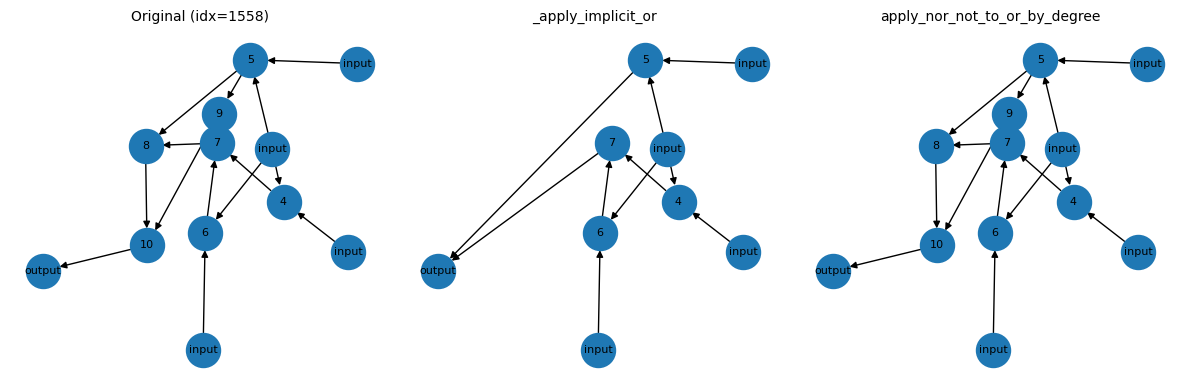

Comparing transforms:  14%|█▍        | 2231/15928 [00:13<00:30, 454.21graph/s]

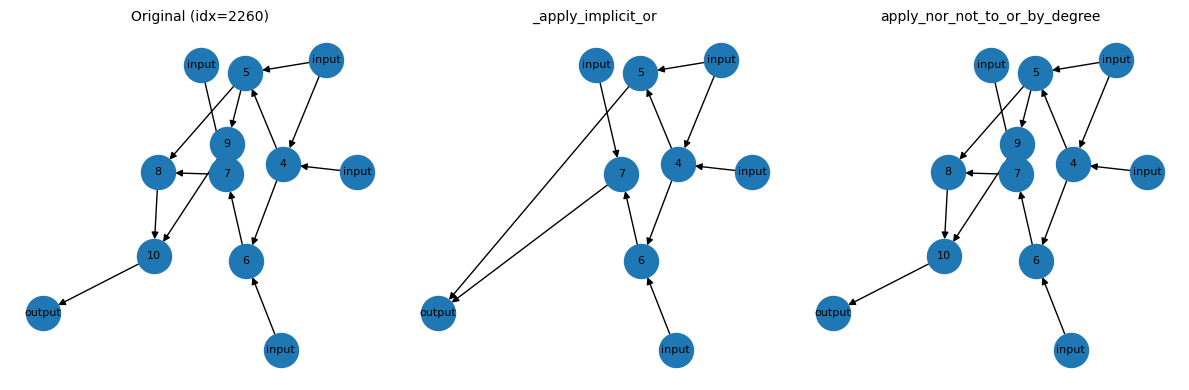

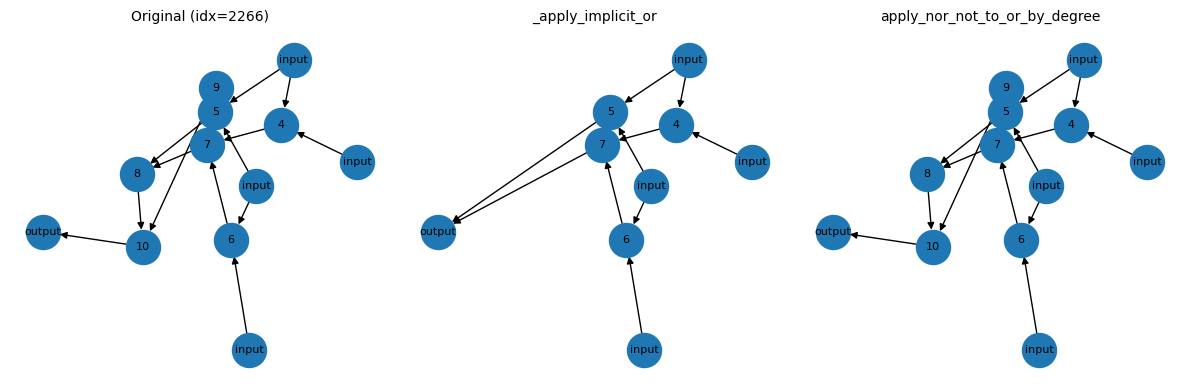

Comparing transforms: 100%|██████████| 15928/15928 [00:57<00:00, 276.51graph/s]

7630 / 15928 graphs changed after _apply_implicit_or (up to isomorphism).
7624 / 15928 graphs changed after apply_nor_not_to_or_by_degree (up to isomorphism).
19 / 15928 graphs where the two transformed outputs differ (non-isomorphic).
{'count_changed_implicit': 7630, 'count_changed_degree': 7624, 'changed_indices_implicit': [13, 15, 20, 29, 32, 37, 39, 42, 44, 52, 64, 67, 70, 82, 84, 104, 108, 111, 121, 123, 124, 125, 127, 128, 129, 130, 132, 135, 136, 137, 138, 144, 145, 146, 147, 148, 151, 154, 155, 158, 159, 163, 165, 167, 168, 169, 170, 171, 173, 176, 178, 179, 181, 186, 189, 190, 191, 192, 193, 194, 198, 203, 204, 205, 208, 209, 210, 211, 214, 227, 239, 248, 255, 268, 275, 278, 284, 288, 305, 312, 335, 339, 341, 344, 346, 364, 373, 969, 1544, 1558, 2260, 2266, 2815, 2828, 2855, 2857, 2859, 2865, 2866, 2867, 2873, 2877, 2878, 2881, 2885, 2886, 2896, 2897, 2898, 2899, 2900, 2901, 2903, 2904, 2905, 2906, 2908, 2912, 2914, 2933, 2938, 2941, 2944, 2953, 2955, 2957, 2960, 2962, 2965, 2

In [10]:
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

def _safe_node_match(keys):
    if not keys:
        return None
    def _nm(a, b):
        return all(a.get(k) == b.get(k) for k in keys)
    return _nm

def _safe_edge_match(keys):
    if not keys:
        return None
    def _em(a, b):
        return all(a.get(k) == b.get(k) for k in keys)
    return _em

def _draw_single_graph(G, title="", pos=None, node_label_key=None, ax=None):
    """Utility: draw a single graph with optional fixed pos and labels."""
    if ax is None:
        ax = plt.gca()

    # Use a consistent layout across variants for readability
    if pos is None:
        pos = nx.spring_layout(G, seed=0)

    # Node labels: attribute (if provided) or the node id
    if node_label_key:
        labels = {n: G.nodes[n].get(node_label_key, str(n)) for n in G.nodes()}
    else:
        labels = {n: str(n) for n in G.nodes()}

    nx.draw_networkx(
        G, pos=pos, with_labels=True, labels=labels,
        node_size=600, font_size=8, ax=ax
    )
    ax.set_title(title, fontsize=10)
    ax.axis("off")
    return pos

def _plot_triplet(original, g_implicit, g_degree, node_label_key=None, idx=None):
    """Plot Original vs _apply_implicit_or vs apply_nor_not_to_or_by_degree, using a consistent layout."""
    # Base layout from the original for stability
    pos = nx.spring_layout(original, seed=0)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    _draw_single_graph(original, title=f"Original (idx={idx})", pos=pos, node_label_key=node_label_key, ax=axes[0])

    # Reuse 'pos' when possible; for missing nodes, networkx will ignore positions
    _draw_single_graph(g_implicit, title="_apply_implicit_or", pos=pos, node_label_key=node_label_key, ax=axes[1])
    _draw_single_graph(g_degree,   title="apply_nor_not_to_or_by_degree", pos=pos, node_label_key=node_label_key, ax=axes[2])
    plt.tight_layout()
    plt.show()

def graphs_changed_by_implicit_or(
    graphs,
    node_attr_keys=None,
    edge_attr_keys=None,
    show_progress=True,
    plot_differences=True,
    node_label_key=None,
):
    """
    Compare each graph to:
      (A) its _apply_implicit_or-transformed version
      (B) its apply_nor_not_to_or_by_degree-transformed version (degree-inferred NOR->NOT->OUT -> OR)

    Report:
      - Which graphs change (up to isomorphism) under each transform.
      - Where the two transforms produce different outputs.
      - Optionally plot triplets (original, A, B) for differing results.

    Parameters
    ----------
    graphs : list[networkx.Graph or DiGraph]
    node_attr_keys : list[str] | None
        Node attributes to include in isomorphism tests (for all comparisons).
    edge_attr_keys : list[str] | None
        Edge attributes to include in isomorphism tests (for all comparisons).
    show_progress : bool
        Whether to show a tqdm progress bar.
    plot_differences : bool
        If True, plot graphs where A != B (non-isomorphic).
    node_label_key : str | None
        If provided, use this node attribute as the label in plots; otherwise use node ids.

    Returns
    -------
    summary : dict
        {
          "count_changed_implicit": int,
          "count_changed_degree": int,
          "changed_indices_implicit": list[int],
          "changed_indices_degree": list[int],
          "count_outputs_differ": int,
          "indices_outputs_differ": list[int],
        }
    """
    node_match = _safe_node_match(node_attr_keys)
    edge_match = _safe_edge_match(edge_attr_keys)

    iterator = enumerate(graphs)
    if show_progress:
        iterator = tqdm(iterator, total=len(graphs), desc="Comparing transforms", unit="graph")

    changed_indices_implicit = []
    changed_indices_degree = []
    indices_outputs_differ = []

    for i, g in iterator:
        # Transform A: your existing implicit-OR logic
        g_impl = _apply_implicit_or(g.copy())

        # Transform B: the degree-inferred NOR->NOT->OUT replacement
        g_deg = apply_nor_not_to_or_by_degree(g.copy())

        # Compare each transform to the original
        iso_impl_vs_orig = nx.is_isomorphic(g, g_impl, node_match=node_match, edge_match=edge_match)
        iso_deg_vs_orig  = nx.is_isomorphic(g, g_deg,  node_match=node_match, edge_match=edge_match)

        if not iso_impl_vs_orig:
            changed_indices_implicit.append(i)
        if not iso_deg_vs_orig:
            changed_indices_degree.append(i)

        # Compare the two outputs to each other
        iso_impl_vs_deg = nx.is_isomorphic(g_impl, g_deg, node_match=node_match, edge_match=edge_match)
        if not iso_impl_vs_deg:
            indices_outputs_differ.append(i)
            if plot_differences:
                _plot_triplet(g, g_impl, g_deg, node_label_key=node_label_key, idx=i)

    count_changed_implicit = len(changed_indices_implicit)
    count_changed_degree   = len(changed_indices_degree)
    count_outputs_differ   = len(indices_outputs_differ)

    print(f"{count_changed_implicit} / {len(graphs)} graphs changed after _apply_implicit_or (up to isomorphism).")
    print(f"{count_changed_degree} / {len(graphs)} graphs changed after apply_nor_not_to_or_by_degree (up to isomorphism).")
    print(f"{count_outputs_differ} / {len(graphs)} graphs where the two transformed outputs differ (non-isomorphic).")

    return {
        "count_changed_implicit": count_changed_implicit,
        "count_changed_degree": count_changed_degree,
        "changed_indices_implicit": changed_indices_implicit,
        "changed_indices_degree": changed_indices_degree,
        "count_outputs_differ": count_outputs_differ,
        "indices_outputs_differ": indices_outputs_differ,
    }

# --- Example usage ---
summary = graphs_changed_by_implicit_or(
    UNIQUE_GRAPHS,
     show_progress=True,
     plot_differences=True,
     node_label_key="type",     # pretty labels in plots, optional
 )
print(summary)


Node 3: {}
Node 4: {}
Node 5: {}
Node 6: {}
Node 0: {'type': 'input'}
Node 1: {'type': 'input'}
Node 2: {'type': 'input'}
Node 7: {'type': 'output'}


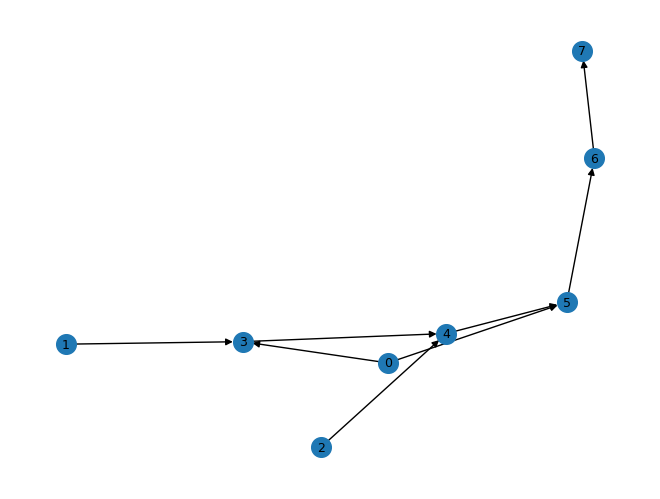

In [22]:
G_copy = UNIQUE_GRAPHS[242].copy()
nx.draw(G_copy, with_labels=True, node_size=200, font_size=9)
for node, attrs in G_copy.nodes(data=True):
    print(f"Node {node}: {attrs}")

In [23]:
size_input_to_OR_gate = 2

output_nodes = [n for n in G_copy if G_copy.out_degree(n) == 0]
output_nodes

[7]

In [24]:


output_node = output_nodes[0]
results_check_implicit_OR_existence = check_implicit_OR_existence_v3(G_copy, output_node, 2)
results_check_implicit_OR_existence       


{'None': {'is_there_an_implicit_OR': False,
  'number_of_nodes_available_for_removal': 0,
  'cut': [],
  'cone': []}}

In [25]:
feasible_cuts = exhaustive_cut_enumeration_dag(G_copy, size_input_to_OR_gate, output_node, filter_redundant=True)

feasible_cuts

[(0, 4), (5,), (6,)]

In [26]:
feasible_cuts_of_size_n = [cut for cut in feasible_cuts if len(cut) == size_input_to_OR_gate]
feasible_cuts_of_size_n
    

[(0, 4)]

In [27]:
feasible_cuts_of_size_n_fof = [cut for cut in feasible_cuts_of_size_n if is_fanout_free_standalone(G_copy, output_node, cut) == True]    
feasible_cuts_of_size_n_fof    

[(0, 4)]

In [28]:
feasible_cuts_of_size_input_to_OR_gate = feasible_cuts_of_size_n_fof
feasible_cuts_of_size_input_to_OR_gate

[(0, 4)]

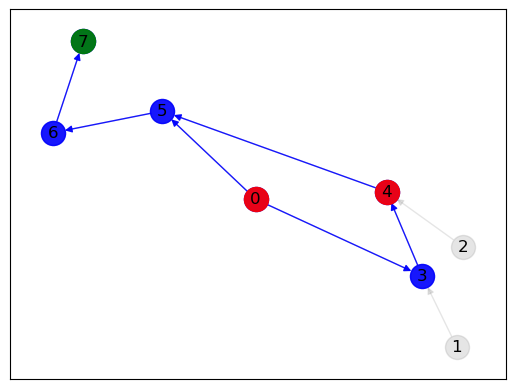

{}

In [29]:
results = {}

for cut_index, cut in enumerate(feasible_cuts_of_size_input_to_OR_gate):
    subgraph = generate_subgraph(G_copy, output_node, cut, draw=True)
    
    #ensure the cut is clean input boundary
    if len([n for n in subgraph if subgraph.in_degree(n) == 0]) != len(cut):
        continue
    
    cone = set(subgraph.nodes()) - set(cut) - {output_node}
    truth_table = calculate_truth_table(subgraph)
    binary_str = ''.join(str(output[0]) for inputs, output in sorted(truth_table.items()))
    truth_table_int = int(binary_str, 2)

    key_name = f"implicit_OR_{cut_index}"
    if (size_input_to_OR_gate == 2 and truth_table_int == 7) or (size_input_to_OR_gate == 3 and truth_table_int == 127):
        # Found an implicit OR
        # number_of_nodes_available_for_removal = (nodes in the subgraph) - (nodes in the cut) - (output node, since this node is not a gate)
        number_of_nodes_available_for_removal = len(subgraph.nodes()) - len(cut) - 1
        results[key_name] = {
            "is_there_an_implicit_OR": True,
            "number_of_nodes_available_for_removal": number_of_nodes_available_for_removal,
            "cut": list(cut),
            "cone": list(cone)
        }
    else:
        results[key_name] = {
            "is_there_an_implicit_OR": False,
            "number_of_nodes_available_for_removal": 0,
            "cut": list(cut),
            "cone": list(cone)
        }

# Filter out the entries where no implicit OR is found
results = {k: v for k, v in results.items() if v["is_there_an_implicit_OR"]}
results

In [30]:
'''

cut = (1, 3)
cone = (4, 5)
G_test = add_implicit_OR_to_dag_v2(G_copy, output_node, cut, cone)

generate_subgraph(G_test, output_node, cut, draw=True)

SyntaxError: EOF while scanning triple-quoted string literal (671023776.py, line 7)